# 분류

## 1. MNIST

네. 또 MNIST입니다. 머신러닝 분야의 hello world죠?

사이킷런에서는 MNIST를 기본 데이터셋으로 제공하고 있습니다. 한번 MNIST 데이터셋을 다운받아서 분류에 대해서 같이 공부해봅시다.


In [1]:
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [3]:
X, y = mnist.data, mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있습니다. 이미지가 28x28 픽셀이기 때문입니다.

개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냅니다. 데이터셋에서 이미지 하나를 확인해보겠습니다. 샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸고 맷플롯립의 `imshow()` 함수를 사용해 그리면 됩니다.

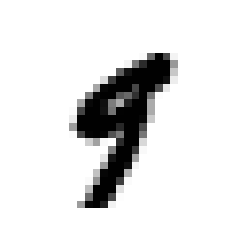

In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

some_digits = X[36000]
some_digit_image = some_digits.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

실제 레이블도 한번 확인해봅시다.

In [5]:
y[36000]

'9'

9같이 보였는데 딱 9네요.

가장 먼저 우리는 전에 했던대로 테스트 세트를 따로 떼어놓고 시작해봅시다.

In [6]:
import numpy as np
y = y.astype(np.int)

In [7]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만들겠습니다. 

아래와 같은 방법으로 데이터세트를 섞을 수 있습니다.

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 2. 이진 분류기 훈련

문제를 단순화해서 하나의 숫자만을 식별해보도록 합시다. 한번 5를 식별해보도록 합시다.

이 "5-감지기"는 "5임", "5 아님"의 이진 분류기의 한 예입니다. 분류 작업을 위해 타깃 벳터를 만들어보겠습니다.


In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
print(y_train_5.shape, y_test_5.shape)

(60000,) (10000,)


분류모델을 하나 선택해서 훈련시켜보도록 하겠습니다. 사이킷런의 `SGDClassifier` 클래스를 사용해 **확률적 경사하강법 (SGD)** 분류기로 시작해봅시다.

이 분류기는 매우 큰 데이터셋을 효율적으로 처리할 수 있다는 장점을 가지고 있습니다. SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 *온라인 학습*에 잘 들어맞습니다. 

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [12]:
sgd_clf.predict([some_digits])

array([False])

분류기는 9라는 이미지가 5가 아니다고 추측했습니다. 

그럼 모델의 성능을 한번 평가해봅시다.

## 3. 성능 측정

분류기 평가는 회귀 모델보다 사용할 수 있는 성능 지표가 많습니다. 한번 차근차근 살펴보도록 합시다!

### 3.1 교차 검증을 사용한 정확도 측정

`cross_val_score()` 함수로 폴드가 3개인 K-겹 교차 검증을 사용해 `SGDClassifier` 모델을 평가해보겠습니다.

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9565 , 0.96845, 0.9678 ])

모든 교차 검증 폴드에 대해 **정확도**가 95% 이상입니다! 

모든 이미지를 "5 아님" 클래스로 분류하는 더미 분류기를 만들어 비교해봅시다.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91145, 0.90905, 0.90845])

네 그렇습니다. 정확도가 90% 이상 나왔습니다. 이게 어떻게 된 일일까요?

이미지의 10%정도만 숫자 5이기 때문에 무조건 "5아님"으로 예측해도 정확도가 90%입니다. 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줍니다. 특히 **불균형한 데이터셋**을 다룰 때에는 더욱 그렇습니다.

### 3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**(confusion matrix)입니다. 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것입니다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 합니다. 테스트 세트로 예측을 만들 수는 있지만 여기서는 사용하면 안됩니다. 대신 `cross_val_predict()` 함수를 사용하도록 합시다. 


In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`cross_val_score()` 함수처럼 `cross_val_predict()` 함수는 K-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환합니다. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됩니다.

이제 `confusion_matrix()` 함수를 사용해 오차 행렬을 만들어봅시다. 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 됩니다.

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54092,   487],
       [ 1658,  3763]])

오차 행렬의 **행**은 **실제 클래스**를 나타내고, **열**은 **예측한 클래스**를 나타냅니다. 


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FEojHI%2FbtqBuwXbsUN%2F1Tt2KW49Zp8ZM7tpBWHUcK%2Fimg.png" width="400">


오차행렬이 많은 정보를 제공해주지만, 가끔 요약된 지표가 필요할 때도 있습니다. 

1. 정밀도 (precision)

$$ 정밀도 = \frac{TP}{TP+FP}$$

- TP는 진짜 양성의 수고, FP는 거짓 양성의 수입니다.
- 양성 예측의 정확도를 나타낼때 사용하는 것으로, 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 구할 수 있습니다.

2. 재현율 (recall)

$$ 재현율 = \frac{TP}{TP+FN} $$

- TP는 진짜 양성의 수, FN은 거짓 음성의 수입니다.
- 분류기가 정확하게 감지한 양성 샘플의 비율을 나타냅니다. 민감도(sensitivity) 또는 진짜 양성 비율(true positive rate) 이라고도 합니다.

### 3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공합니다.

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8854117647058823
0.6941523704113632


이제 '5-감지기'가 정확도만큼 매력적이지는 않은 것 같습니다. 5로 판별된 이미지 중 87%만 정확합니다.

정밀도와 재현율을 **F1 Score** 라고 하는 하나의 숫자로 만들면 편할 때가 많습니다. 특히 두 분류기를 비교할 때 그렇습니다.

F1 점수는 정밀도와 재현율의 *조화 평균*을 이용해서 구할 수 있습니다.

$$F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN+TP}{2}}$$

$F_1$ 점수를 계산하려면 `f1_score()` 함수를 호출하면 됩니다.

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7782028745734672

정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높습니다. 하지만 이게 항상 바람직한 것은 아닙니다. 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할수도 있습니다.

정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지입니다. 이를 **정밀도/재현율 트레이드오프**라고 합니다.

### 3.4 정밀도/재현율 트레이드 오프

`SGDClassifier`가 분류를 어떻게 결정하는지 살펴보며 이 트레이드 오프를 이해해보겠습니다.

이 분류기는 **결정 함수**를 사용하여 각 샘플의 점수를 계산합니다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고, 그렇지 않으면 음성 클래스에 할당합니다.
이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당합니다. 

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있습니다. 분류기의 `predict()` 함수 대신 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있습니다.

이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있습니다.





In [20]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([-226688.19885827])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

`SGDClassifier`의 임계값이 0이므로 위 코드는 `predict()` 메소드와 같은 결과를 반환합니다. 임계값을 높이면 제대로 예측할 확률이 더 높아지겠죠? 

임계값을 높이면 **재현율이 줄어듭니다.** 적절한 임계값은 `cross_val_predict()`를 통해 훈련 세트에 있는 모든 샘플의 점수를 구한 후 결정 점수를 반환해 모든 임계값에 대해 정밀도와 재현율을 계산해가면서 커스터마이징할 수 있습니다.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

멧플롯립을 이용해 임계값의 함수로 정밀도와 재현율을 그려봅시다.

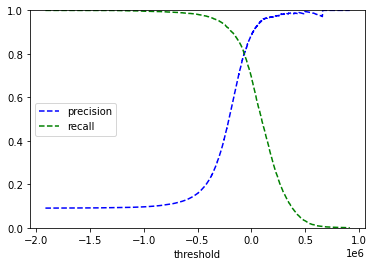

In [24]:
def plot_precision_reall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("threshold")
    plt.ylim([0, 1])
    plt.legend(loc="center left")

plot_precision_reall_vs_threshold(precisions, recalls, thresholds)
plt.show()

이렇게 그래프로 확인하고 최선의 정밀도/재현율 트레이드 오프를 선택하면 도움이 됩니다.

## 5. ROC 곡선

**수신기 조작 특성**(receiver operating characteristic) (ROC) 곡선도 이진 분류에서 널리 사용하는 도구입니다. 정밀도/재현율 곡선과 매우 비슷하지만 ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 **거짓 양성 비율**에 대한 **진짜 양성 비율**을 나타냅니다. 

ROC 곡선은 민감도(재현율)에 대한 **1-특이도**(true negative rate) 곡선입니다.. 

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

마찬가지로 맷플롯립을 사용해 TPR에 대한 FPR 곡선을 나타낼 수 있습니다. 

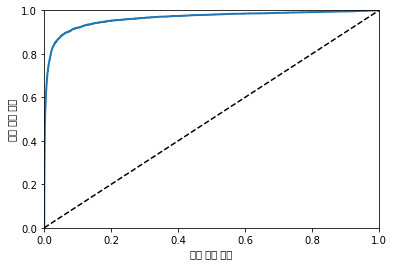

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("거짓 양성 비율")
    plt.ylabel("진짜 양성 비율")

plot_roc_curve(fpr, tpr)
plt.show()

여기에서도 트레이드오프가 있습니다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어납니다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻합니다. 좋은 분류기는 이 점선으로부터 최대한 멀리 떨어져있어야 합니다.

*곡선 아래의 면적*(area under the curve)(AUC)을 측정하면 분류기들을 비교할 수 있습니다. 완벽한 분류기는 ROC의 AUC가 1입니다. 

사이킷런은 ROC의 AUC를 계산하는 함수를 제공하고 있습니다.

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9636571848103124

`RandomForestClassifier`를 훈련시켜 `SGDClassifier`의 ROC 곡선과 ROC AUC 점수를 비교해보겠습니다.

가장 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 합니다. 하지만 작동 방식의 차이 때문에 `RandomForestClassifier`에는 `decision_function()`메서드가 없습니다. 대신 `predict_proba()`가 있습니다. 사이킷런의 분류기는 이 두 메서드 중 하나 또는 둘 모두를 가지고 있습니다. `predict_proba()` 메소드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환합니다.

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

ROC 곡선을 그리려면 확률이 아니라 점수가 필요합니다. 양성 클래스의 확률을 점수로 사용해봅시다.

In [29]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다. 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

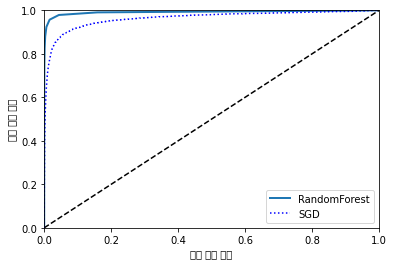

In [30]:
plot_roc_curve(fpr_forest, tpr_forest, label="RandomForest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend()
plt.show()

그림에서 볼 수 있듯이 `RandomForestClassifier`가 성능이 좀 더 좋아보입니다. 한번 ROC AUC 점수도 구해봅시다. 

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9919577253139416

정밀도와 재현율 점수를 계산해보면 98.5% 정밀도와 82.8% 재현율이 나옵니다. 나쁘지 않군요!

이제 이 다음에는 다중 분류를 해보도록 합시다.

## 4. 다중 분류

이진분류가 두개의 클래스를 구별하는 반면 **다중 분류기**(multiclass classifier)는 둘 이상의 클래스를 구별할 수 있습니다.

(랜덤 포레스트나 나이브베이즈와 같은) 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, (서포트 벡터 머신이나 선형분류기 같은) 다른 알고리즘은 이진 분류만 가능합니다. 하지만 이진 분류기를 사용해 다중 클래스를 분류하는 기법도 많습니다.

예를 들어 특성 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지를 10개 훈련시켜 클래스가 10개인 숫자 임지ㅣ 분류 시스템을 만들 수 있습니다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 클래스를 선택하면 됩니다. 이를 **일대 다**(one-versus-all)(OvA) 전략이라고 합니다.

또 다른 전략은 0과 1 구별, 0과 2구별, 1과 2구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것입니다. 이를 **일대일**(one-versus-all)(OvO) 전략이라고 합니다. 클래스가 n개라면 분류기는 $\frac{n\times(n-1)}{2}$개가 필요합니다. OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 점입니다.

(서포트 벡터 머신같은) 일부 알괴즘은 훈련 세트의 크기에 미감해서 큰 훈련 세트에서 별개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호합니다. 하지만 대부분의 이진 분류 알고리즘에서는 OvA를 선호합니다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 자동으로 감지해 OvA를 적용합니다. `SGDClassifier`를 적용해보겠습니다.


In [32]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digits])

array([4])

앗. 4가 나오네요.

이 코드는 0에서 9까지 원래 타깃 클래스 (y_train)을 사용해 `SGDClassifier`를 훈련시킵니다. 그런 다음 예측 하나를 만듭니다. 내부에서는 사이킷런이 실제로 10개의 이진분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택합니다.

한번 실제로도 그런지 확인해봅시다. `decision_function()` 메서드를 호출하면 확인할 수 있습니다. 이 메서드는 샘플 당 하나의 점수가 아니라 클래스마다 하나씩, 총 10개의 점수를 반환합니다.

In [33]:
some_digit_score = sgd_clf.decision_function([some_digits])
some_digit_score

array([[-906500.15725169, -370737.87266927, -826103.25457394,
        -256618.72107322,   29355.36306543, -237370.70787798,
        -732141.39980238, -229264.3932638 , -345578.29942858,
        -122297.00491062]])

잘못된 에를 선택했나봅니다 ^^; 전부 다 만족스럽게 점수가 나오지는 않네요.

가장 높은 점수가 4에 해당하는 점수입니다.

In [34]:
np.argmax(some_digit_score)

4

In [35]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
sgd_clf.classes_[4]

4

사이킷런에서는 OvO나 OvA을 사용하도록 강제하려면 `OneVsOneClassifier`나 `OneVsRestClassifier`를 사용합니다.

간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됩니다. 아래 코드는 `SGDClassifier`를 기반으로 OvO 전략을 사용하는 다중 분류기를 만듭니다.

In [37]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digits])

array([9])

In [38]:
len(ovo_clf.estimators_)

45

`RandomForestClassifier`를 훈련시키는 것도 간단합니다.

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digits])

array([9])

야는 제대로 인식을 하네요 ㅎㅎ;

이 경우 랜덤포레스트 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvA나 OvO를 적용할 필요가 없습니다. `predict_proba()`메서들르 호출하면 분류기가 직접 각 샘플에부여한 클래스별 확률을 얻을 수 있습니다.

In [40]:
forest_clf.predict_proba([some_digits])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.8]])

이 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있다는 것을 알 수 있습니다! 0.9는 9일 것을 90% 확신하고 있다는 뜻입니다.

그러면 교차검증을 이용해 분류기를 평하개보도록 하겠습니다. `cross_val_score()` 함수를 사용해 `SGDClassifier`의 정확도를 평가해보겠습니다.

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8786, 0.8709, 0.8728])

In [42]:
# RandomForestClassifier도 한번 평가해봅시다!
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94235, 0.94185, 0.939  ])

`SGDClassifier`는 모든 폴드에서 85% 이상의 정확도를 보여주고, `RandomForestClassifier`는 더 놓은 점수를 보여주고 있네요.

점수가 아주 나쁘지는 않지만, 성능을 더 높일 여지가 있습니다. 간단하게 입력의 스케일을 조정하면 정확도를 더 높일 수 있습니다.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9107, 0.9113, 0.9084])

## 5. 에러 분석

실제 프로젝트라면 데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 `GridSearchCV`를 사용해 하이퍼 파라미터를 세밀하게 튜닝하고, 앞 장에서 한 것처럼 가능한 자동화합니다.

이번에는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보도록 하겠습니다. 한가지 방법은 만들어진 **에러의 종류를 분석**하는 것입니다.

먼저 오차행렬을 살펴볼 수 있습니다. `cross_val_predict()` 함수를 상ㅇ해 예측을 만들고 이전처럼 `confusion_matrix()` 함수를 호출합니다.

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    2,   23,    9,   10,   44,   43,    9,   42,    4],
       [   2, 6483,   43,   26,    6,   40,    7,   10,  115,   10],
       [  59,   40, 5335,  100,   66,   23,  100,   54,  163,   18],
       [  50,   38,  147, 5338,    2,  227,   39,   52,  150,   88],
       [  23,   27,   40,    9, 5352,    9,   59,   27,   90,  206],
       [  76,   43,   32,  171,   70, 4633,  109,   31,  162,   94],
       [  39,   23,   45,    1,   42,   99, 5623,    5,   40,    1],
       [  23,   19,   74,   33,   51,   10,    7, 5814,   16,  218],
       [  53,  151,   68,  146,   13,  156,   59,   25, 5043,  137],
       [  40,   36,   26,   89,  163,   34,    2,  217,   92, 5250]])

많은 숫자들이 출력됩니다. 오차 행렬을 맷플롯립의 `matshow()` 함수를 사용해 이미지로 표현하면 보기가 편리해집니다.

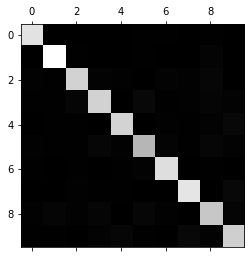

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을나타내는 주 대각선에 있으므로 매우 좋아보입니다.

숫자 5는 다른 곳보다 조금 어두워 보입니다. 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 것입니다.

그래프의 에러 부분에 초점을 맞춰보겠습니다. 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교합니다.

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

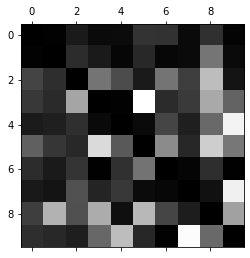

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있습니다. 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냅니다.

클래스 8과 9의 열이 상당히 밝으므로 많은 이미지가 8과 9로 잘못 분류되었음을 암시합니다. 비슷하게 8과 9의 행도 밝으므로 숫자 8과 9가 다른 숫자들과 혼돈이 자주 된다는 것을 말해주고 있습니다. 
반대로 클래스 1의 열은 매우 어두우므로 대부분의 클래스가 잘 구분된다는 것을 알 수 있습니다. 에러가 정확하게 대칭이 아닙니다. 예를들어 숫자가 5가 8로 잘못 분류된 경우보다 8이 5로 잘못 분류된 경우가 더 많습니다.

오차행렬을 분석하면 분류기 성능 향상 방안에 대한 통찰을 얻을 수 있습니다. 이 그래프를 살펴보면 3과 5가 서로 혼돈되는 것을 보완하고 8과 9를 더 잘 분류할 수 잇또록 새건할 필요가 있어보입니다.

개개의 에러를 분석해보면 분류기가 무슨 일을 하고있고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있지만 더 어렵고 시간이 오래 걸립니다. 얘를들어 3과 5의 샘플을 그려보겠습니다. 

In [48]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [49]:
def plot_digits(lst):
    fig, ax = plt.subplots()
    for i in range(25):
        plt.subplot(5, 5, i+1)
        tmp = lst[i].reshape(28, 28)
        plt.imshow(tmp, cmap=matplotlib.cm.binary, interpolation="nearest")
        plt.axis("off")
    #plt.close()
    return fig

<Figure size 864x576 with 0 Axes>

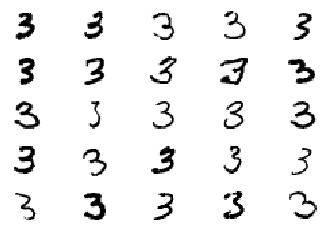

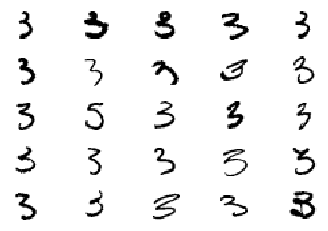

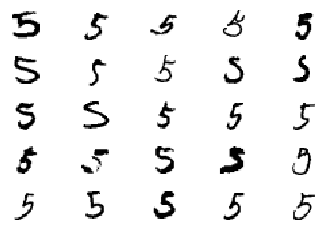

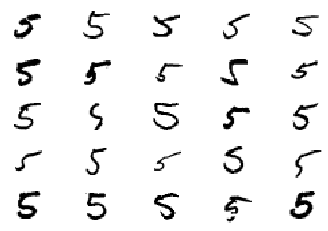

In [50]:
plt.figure(figsize=(12, 8))
plot_digits(X_aa[:25])
plot_digits(X_ab[:25])
plot_digits(X_ba[:25])
plot_digits(X_bb[:25])
plt.show()

대부분의 3인데 5로 분류된 이미지와 5에서 3으로 분류된 이미지들을 보면 거의 다 제대로 쓰여진 이미지같은데 잘못 분류하는 것 같습니다. 원인은 선형 모델인 `SGDClassifier`를 사용했기 때문입니다. 

선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산합니다. 따라서 3과 4는몇개의 픽셀만 다르기 때문에 쉽게 혼동합니다.

이러한 3과 5의 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되어있지 않도록 전처리하는 것입니다. 

## 6. 다중 레이블 분류

지금까지는 각 샘플이 하나의 클래스에만 담겼습니다. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있습니다.

여러 개의 이진 레이블을 출력하는 시스템을 **다중 레이블 분류**(multilabel classification) 이라고 합니다.

간단한 예시를 살펴봅시다.

In [51]:
from sklearn.neighbors import KNeighborsClassifier


y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두개의 타깃 레이블이 담긴 `y_multilabel` 배열을 만듭니다.

첫 번째 숫자가 큰 값(7, 8, 9)인지를 나타내고, 두번째는 홀수인지를 나타냅니다. 그 다음 줄이 `KNeighborClassifier` 인스턴스를 만들고 다중 타깃 배열을 사용해서 훈련시킵니다. 이제 예측을 만들려면 레이블이 두 개 출력됩니다.

In [52]:
knn_clf.predict([some_digits])

array([[ True,  True]])

9고 홀수니까 올바르게 분류되었네요!

다중 레이블 분류기를 평가하는 방법은 많습니다. 적절한 지표는 프로젝트에 따라 다릅니다.

예를들어 각 레이블의 $F_1$ 점수를 구하고 간단하게 평균 점수를 계산합니다. 아래 코드는 모든 레이블에 대한 $F_1$점수의 평균을 계산하는 방법입니다.

In [53]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=1)
#f1_score(y_multilabel, y_train_knn_pred, average='macro')

실제로는 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것입니다.

이를 원하지 않다면 간단하게 레이블에 클래스의 **지지도**(support)를 가중치로 두는 방법입니다. 이렇게 하려면 이전 코드에서 `average="weighted"`로 설정하면 됩니다.

## 7. 다중 출력 분류

마지막으로 알아볼 분류 작업은 **다중 출력 다중 클래스 분류**입니다. (또는 간단히 다중 출력 분류)

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것입니다.

이를 위해 이미지에서 노이즈를 제거하는 시스템을 만들어보겠습니다. 노이즈가 숫자가 많은 이미지를 입력으로 받고 깨끗한 숫자
이미지를 MNIST처럼 픽셀의 강도를 담은 배열로 출력합니다. 분류기의 출력이 다중 레이블이고 각 레이블은 여러개의 값을 가집니다.
그러므로 이 예는 다중 출력 분류 시스템입니다.

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이 `randint()` 함수를 사용하여 픽셀 강도에 노이즈를 추가하겠습니다.
타깃 이미지는 원본 이미지입니다.

In [54]:
from numpy import random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100,  (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

테스트 세트에서 이미지를 하나 선택합시다.

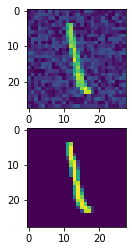

In [55]:
idx = 36000

plt.subplot(2, 1, 1)
plt.imshow(X_train_mod[idx].reshape(28, 28))
plt.subplot(2, 1, 2)
plt.imshow(y_train_mod[idx].reshape(28, 28))
plt.show()

왼쪽이 노이즈가 섞인 이미지이고 오른쪽이 깨끗한 타겟 이미지입니다. 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보겠습니다.


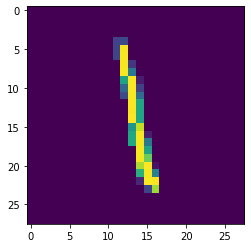

In [56]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[idx]])

plt.imshow(clean_digit.reshape(28, 28))
plt.show()

노이즈가 꼈던 이미지를 학습시켰더니 제대로 깔끔하게 낭네요! 타깃과 매우 비슷합니다. 이것으로 분류에 대한 설명을 마칩니다. 

In [57]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))